深度學習
VGG16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/TibaMe/DLDemo/VGG16/train.zip")
f.extractall("./datasets")

In [4]:
import glob
import pandas as pd
catfs = glob.glob("datasets/train/cat.*.[jJ][pP][gG]")
catans = [0] * len(catfs)
dogfs = glob.glob("datasets/train/dog.*.[jJ][pP][gG]")
dogans = [1] * len(dogfs)
df = pd.DataFrame({
    "path":catfs + dogfs,
    "target":catans + dogans
})
df

,path,target
0,datasets/train/cat.4243.jpg,0
1,datasets/train/cat.6885.jpg,0
2,datasets/train/cat.4789.jpg,0
3,datasets/train/cat.3012.jpg,0
4,datasets/train/cat.12274.jpg,0
...,...,...
24995,datasets/train/dog.1089.jpg,1
24996,datasets/train/dog.8390.jpg,1
24997,datasets/train/dog.9323.jpg,1
24998,datasets/train/dog.7567.jpg,1


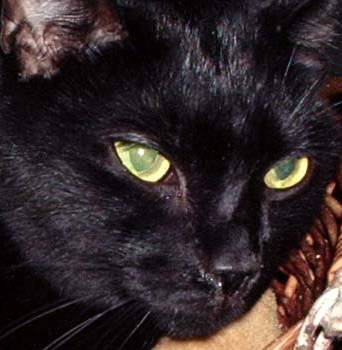

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img
idx = 1
load_img(df["path"][idx])

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

for l in cnn.layers:
    # !!! trainable一定要先設置
    l.trainable = False
# 放在flatten後完全不對
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [0]:
# 訓練以前, 把所有的list, series.... -> nparray
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(df["target"]),
                                                    test_size=0.1)

In [0]:
# 請使用裡面的預處理(不要自己來)
from tensorflow.keras.applications.vgg16 import preprocess_input
# return: (原圖(batch), 處理後圖(batch), 答案(batch))
def dataflow(x, y, batch=20):
    idx = np.random.randint(0, x.shape[0], size=batch)
    x_batch, y_batch = x[idx], y[idx]
    x_ori, x_pre = [], []
    for fp in x_batch:
        img = load_img(fp, target_size=(224, 224))
        img_np = np.array(img)
        # 原本的圖片我存一份
        x_ori.append(img_np)
        img_pre = preprocess_input(img_np)
        # 預處理的圖片
        x_pre.append(img_pre)
    x_ori, x_pre = np.array(x_ori), np.array(x_pre)
    return (x_ori, x_pre, y_batch)

In [0]:
for i in range(20):
    print("-" * 10, i, "-" * 10)
    _, x, y = dataflow(x_train, y_train)
    result = model.train_on_batch(x, y)
    print("[Train]:", result)
    # 如果有時間的話, validate batch可以調高一點
    _, x, y = dataflow(x_test, y_test)
    result = model.test_on_batch(x, y)
    print("[Validate]:", result)

---------- 0 ----------
[Train]: [0.5287672877311707, 0.9538461565971375]
[Validate]: [1.0901901721954346, 0.8500000238418579]
---------- 1 ----------
[Train]: [0.02669619955122471, 1.0]
[Validate]: [0.0014825206017121673, 1.0]
---------- 2 ----------
[Train]: [0.44197291135787964, 0.8999999761581421]
[Validate]: [0.0, 1.0]
---------- 3 ----------
[Train]: [0.09064386039972305, 0.949999988079071]
[Validate]: [1.0840966701507568, 0.949999988079071]
---------- 4 ----------
[Train]: [0.012372611090540886, 1.0]
[Validate]: [0.038489870727062225, 0.949999988079071]
---------- 5 ----------
[Train]: [0.47768455743789673, 0.949999988079071]
[Validate]: [0.0020223406609147787, 1.0]
---------- 6 ----------
[Train]: [0.09579572826623917, 0.949999988079071]
[Validate]: [0.7328404784202576, 0.949999988079071]
---------- 7 ----------
[Train]: [0.22782659530639648, 0.8999999761581421]
[Validate]: [0.00010232893691863865, 1.0]
---------- 8 ----------
[Train]: [0.08278124034404755, 0.949999988079071]
[

In [0]:
model.predict(x)

array([[7.9109469e-10, 1.0000000e+00],
       [5.4497784e-09, 1.0000000e+00],
       [1.0000000e+00, 1.4852644e-28],
       [1.0000000e+00, 4.0815232e-17],
       [0.0000000e+00, 1.0000000e+00],
       [2.5277891e-23, 1.0000000e+00],
       [2.8170413e-21, 1.0000000e+00],
       [1.0000000e+00, 2.1652412e-18],
       [9.3328300e-25, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [5.0837007e-05, 9.9994922e-01],
       [0.0000000e+00, 1.0000000e+00],
       [3.2332482e-05, 9.9996769e-01],
       [1.8938105e-24, 1.0000000e+00],
       [1.3813346e-10, 1.0000000e+00],
       [1.0044555e-27, 1.0000000e+00],
       [1.5559694e-11, 1.0000000e+00],
       [1.0610827e-19, 1.0000000e+00],
       [9.9996507e-01, 3.4876801e-05]], dtype=float32)

In [0]:
timg, tx, ty = dataflow(x_test, y_test, 500)
model.evaluate(tx, ty)

16/16 [==============================] - 1s 63ms/step - loss: 0.4759 - accuracy: 0.9560


[0.47589176893234253, 0.9559999704360962]

In [0]:
# predict_classes: Model沒有
# predict + argmax = predict_classes
# argmax: 幫你找到最大值的index(axis=-1 == axis=1)
pre = model.predict(tx).argmax(axis=-1)
pre

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,

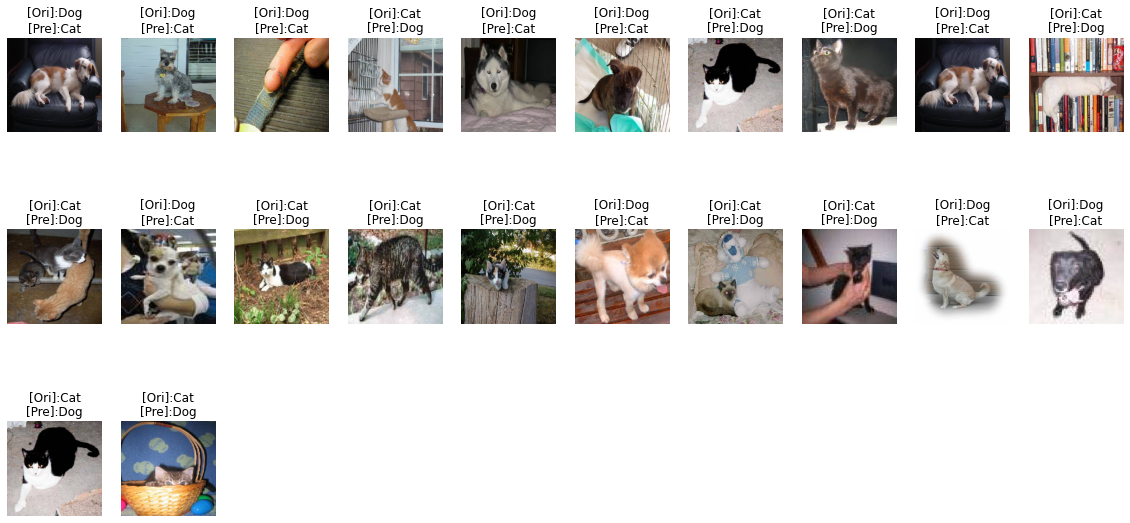

In [0]:
# nonzero: 取出是True的index
# (x座標, y座標, z座標)
trans = ["Cat", "Dog"]
idx = np.nonzero(pre != ty)[0]
# 預測錯誤的圖
false_img = timg[idx]
false_answer = ty[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 10))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)